In [6]:
import numpy as np

from ase import Atoms, units
from ase.calculators.lj import LennardJones
from ase.optimize import BFGS
from ase.constraints import FixedPlane
from math import sqrt, exp
from ase.visualize import view


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import ShuffleSplit
from sklearn.neural_network import MLPRegressor

# Initial cluster setup

## Task 1: LJ potential

$$
V_{\text{LJ}}(\mathbf{r}) = \sum_i^N \sum_{j>i}^N 4 \epsilon_{ij} \left[ \left(\frac{\sigma_{ij}}{|\mathbf{r}_{ij}|} \right)^{12} - \left(\frac{\sigma_{ij}}{|\mathbf{r}_{ij}|} \right)^{6} \right]
$$

$\sigma$ determines the length scale of the interaction (size of the particles) and $\epsilon$ the interaction strength (depth of the potential).  The default values in ASE are $\sigma = 1$ Ang and $\epsilon = 1$ eV.

In [8]:
# set up 2 clusters with 7 atoms each, one 3d, one 2d

d = 1.1

# 3d cluster
clus3d = Atoms('7Ar',[(0.0,0.0,0.0),(d/sqrt(2),d/sqrt(2),0.0),(-d/sqrt(2),d/sqrt(2),0.0),
                      (d/sqrt(2),-d/sqrt(2),0.0),(-d/sqrt(2),-d/sqrt(2),0.0),(0,0,d),(0,0,-d)])
print('\n3D cluster initial positions:')
print(clus3d.get_positions())

# 2d cluster
print('\n2D cluster initial positions:')
clus2d = Atoms('7Ar',[(0.0,0.0,0.0),(d,0.0,0.0),(-d,0.0,0.0),(d/2,d/2*sqrt(3),0.0),
                     (-d/2,d/2*sqrt(3),0.0),(-d/2,-d/2*sqrt(3),0.0),(d/2,-d/2*sqrt(3),0)])
print(clus2d.get_positions())

# set LJ calculator and print out initial energy
ljcalc = LennardJones()
clus3d.calc = ljcalc
clus2d.calc = ljcalc

clus3dpot = clus3d.get_potential_energy()
clus2dpot = clus2d.get_potential_energy()

print('\n')
print(f'3D cluster initial potential energy = {clus3dpot:5.3f} eV')
print(f'2D cluster initial potential energy = {clus2dpot:5.3f} eV')
print('\n')




3D cluster initial positions:
[[ 0.          0.          0.        ]
 [ 0.77781746  0.77781746  0.        ]
 [-0.77781746  0.77781746  0.        ]
 [ 0.77781746 -0.77781746  0.        ]
 [-0.77781746 -0.77781746  0.        ]
 [ 0.          0.          1.1       ]
 [ 0.          0.         -1.1       ]]

2D cluster initial positions:
[[ 0.          0.          0.        ]
 [ 1.1         0.          0.        ]
 [-1.1         0.          0.        ]
 [ 0.55        0.95262794  0.        ]
 [-0.55        0.95262794  0.        ]
 [-0.55       -0.95262794  0.        ]
 [ 0.55       -0.95262794  0.        ]]


3D cluster initial potential energy = -9.038 eV
2D cluster initial potential energy = -12.282 eV




## Task 2: Optimizing the initial cluster structures

In [9]:
# perform initial energy minimizaion
dyn3d = BFGS(clus3d)
dyn3d.run(fmax=0.05)


# constrain 2D cluster to xy-plane
c=[]
for i in range(len(clus2d)):
    c.append(FixedPlane(a=i, direction=[0,0,1]))
clus2d.set_constraint(c)
dyn2d = BFGS(clus2d)
dyn2d.run(fmax=0.05)


# print positions and energy after relaxation
print('\n3D cluster positions after relaxation:')
print(clus3d.get_positions())
clus3dpot = clus3d.get_potential_energy()
print(f'\n3D cluster potential energy after relaxation = {clus3dpot:5.3f} eV')

print('\n2D cluster positions after relaxation:')
print(clus2d.get_positions())
clus2dpot = clus2d.get_potential_energy()
print(f'\n2D cluster potential energy after relaxation = {clus2dpot:5.3f} eV')

# reset all z-values of 2D cluster to zero and plot positions and energy again
# pos2d = clus2d.get_positions()
# for apos in pos2d:
#     apos[2] = 0.0
    
# clus2d.set_positions(pos2d)
# print('\n2D cluster positions after relaxation and reset:')
# print(clus2d.get_positions())
# clus2dpot = clus2d.get_potential_energy()
# print(f'\n2D cluster potential energy after relaxation and reset = {clus2dpot:5.3f} eV')

      Step     Time          Energy         fmax
BFGS:    0 15:52:12       -9.037942        1.1509
BFGS:    1 15:52:12       -9.087128        0.2280
BFGS:    2 15:52:12       -9.088710        0.0317
      Step     Time          Energy         fmax
BFGS:    0 15:52:12      -12.281571        2.6446
BFGS:    1 15:52:12      -12.300262        1.9416
BFGS:    2 15:52:12      -12.415891        0.3876
BFGS:    3 15:52:12      -12.419639        0.0803
BFGS:    4 15:52:12      -12.419798        0.0025

3D cluster positions after relaxation:
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 7.68114033e-01  7.68114033e-01 -4.54907766e-19]
 [-7.68114033e-01  7.68114033e-01 -6.76947056e-20]
 [ 7.68114033e-01 -7.68114033e-01  2.93031638e-19]
 [-7.68114033e-01 -7.68114033e-01  3.47195432e-20]
 [-1.04556106e-19  5.54862210e-20  1.08627728e+00]
 [-3.91133673e-21  2.92589406e-20 -1.08627728e+00]]

3D cluster potential energy after relaxation = -9.089 eV

2D cluster positions after relaxation:
[[ 0.0

In [10]:
# look at the clusters, set 'Scale atomic radii' to 0.5
view(clus2d)

<Popen: returncode: None args: ['/usr/local/bin/python', '-m', 'ase', 'gui',...>

In [11]:
view(clus3d)

<Popen: returncode: None args: ['/usr/local/bin/python', '-m', 'ase', 'gui',...>

## Task 3: Pairwise distances

What is the main disadvantage when directly using Cartesian coordinates?



In [12]:
# make a list of all distances
dist3d = clus3d.get_all_distances()
#print(dist3d)

# sort list
dist3d = np.sort(np.ravel(dist3d))
#print(dist3d)

# remove 0
dist3d = np.trim_zeros(dist3d)
#print(dist3d)

# only every second entry (double counting of bonds)
dist3d = dist3d[::2]
print(dist3d)

#length should be N*(N-1)/2 -> for N=7 there are 21; this will be the input vector to the NN!
print(len(dist3d))
print('\n')

#now the same for the 2D cluster
dist2d = np.trim_zeros(np.sort(np.ravel(clus2d.get_all_distances())))
dist2d = dist2d[::2]
print(dist2d)
print(len(dist2d))

# save original configurations
clus3d_orig_pos = clus3d.get_positions()
clus2d_orig_pos = clus2d.get_positions()


[1.08627728 1.08627728 1.08627728 1.08627728 1.08627728 1.08627728
 1.53622807 1.53622807 1.53622807 1.53622807 1.53622807 1.53622807
 1.53622807 1.53622807 1.53622807 1.53622807 1.53622807 1.53622807
 2.17255457 2.17255457 2.17255457]
21


[1.11848102 1.11848102 1.11848102 1.11848102 1.11848102 1.11848102
 1.11848102 1.11848102 1.11848102 1.11848102 1.11848102 1.11848102
 1.93726595 1.93726595 1.93726595 1.93726595 1.93726595 1.93726595
 2.23696204 2.23696204 2.23696204]
21


usage: ase [-h] [--version] [-T]
           {help,info,test,gui,db,run,band-structure,build,dimensionality,eos,ulm,find,nebplot,nomad-upload,nomad-get,convert,reciprocal,completion,diff,exec}
           ...
ase: error: TclError: no display name and no $DISPLAY environment variable
To get a full traceback, use: ase -T gui ...
usage: ase [-h] [--version] [-T]
           {help,info,test,gui,db,run,band-structure,build,dimensionality,eos,ulm,find,nebplot,nomad-upload,nomad-get,convert,reciprocal,completion,diff,exec}
           ...
ase: error: TclError: no display name and no $DISPLAY environment variable
To get a full traceback, use: ase -T gui ...


# Creating datasets using Monte Carlo sampling

## Task 1: MC sampling function

In [13]:
import ase

def mcstep(config: ase.Atoms, T: float, sigma: float, D: int, rng: np.random.Generator):
    """Metropolis-Hastings algorithm to sample atomic configurations at constant temperature using global random displacement moves from a Gaussian distribution.

    Parameters
    ----------
    config:
        an atomic configuration.
    T:
        temperature of the system
    sigma:
        magnitude of the random displacement
    D:
        dimensionality of the system (either 2 or 3)
    rng:
        a random generator from numpy.random
    
    Return
    ------

    config: ase.Atoms
        the modified configuration
    accetance: int
        whether the move has been accepted
    """
    
    e_old = config.get_potential_energy()
    pos_old = config.get_positions()
    pos_new = config.get_positions()
    # sample random displacements
    displacements = rng.normal(loc=0.0, scale=sigma, size=pos_new.shape)
    pos_new += displacements
    if D == 2:
        # set the z dimension back to 0
        pos_new[:, 2] = 0

    config.set_positions(pos_new)
    e_new = config.get_potential_energy()
    
    # here's the MC acceptance
    dE = e_new - e_old
    if rng.uniform() < exp(-dE/(units.kB*T)):
        config.set_positions(pos_new)
        return config, 1
    else:
        config.set_positions(pos_old)
        return config, 0
    
    

## Task 2: MC sampling and dataset for 3D LJ cluster

In [14]:
from numpy.random import default_rng
rng = default_rng(92458)

In [20]:
# start with original setup
clus3d.set_positions(clus3d_orig_pos)

# set dimensionality
D = 3

# displacement
# set temperature (in K)
# T = 10
# sigma = 0.001
sigma = 0.01
T = 800

# set number of MC steps
mcsteps = 20001

# how often to print energy
nprint = 500

# how often to collect data
ncollect = 20

# initialize acceptance counter
nacc = 0
X3d = []
y3d = []

# do a simple MC sampling to create a set of configurations
for i in range(mcsteps):
    
    clus3d, acc = mcstep(clus3d, T, sigma, D, rng)
    
    if acc:
        nacc += 1
    if (i % nprint) == 0:
        print(i,clus3d.get_potential_energy())
        
    if (i % ncollect) == 0:
        dist = clus3d.get_all_distances()
        dist = np.trim_zeros(np.sort(np.ravel(dist)))
        X3d.append(dist[::2])
        y3d.append(clus3d.get_potential_energy())
        
# print acceptances
#print(nacc)
print(f'\nAcceptance ratio: {float(nacc)/float(mcsteps):5.3f}')

X3d = np.array(X3d)
y3d = np.array(y3d)

print(len(X3d))
print(len(y3d))

# some setups:
# T = 800 K, sigma = 0.01
# T = 10 K, sigma = 0.001

0 -9.088710494840697
500 -12.106957932673904
1000 -13.934596747713362
1500 -14.149515329144899
2000 -15.311131093518643
2500 -16.00117289783819
3000 -16.070463223984827
3500 -15.942722884681928
4000 -15.623993668685513
4500 -15.614194270329062
5000 -15.871589350745113
5500 -16.09800856177129
6000 -15.877865723367828
6500 -15.871992693372267
7000 -15.832837914499997
7500 -16.006524907312617
8000 -15.926263783294763
8500 -15.633103061345409
9000 -16.01879119312574
9500 -15.791995473988383
10000 -16.090673916786997
10500 -15.417599210542525
11000 -15.60416701483232
11500 -15.969699655663828
12000 -15.934787717965415
12500 -15.960860157660456
13000 -15.943797616562492
13500 -15.352139108543883
14000 -15.998610233511972
14500 -15.992790701134599
15000 -15.842014887462717
15500 -15.80412976179443
16000 -16.22746358146794
16500 -15.66229185023426
17000 -15.612980249254065
17500 -15.853474703864277
18000 -16.003346616121686
18500 -15.899772330753928
19000 -15.948629053312704
19500 -15.39674336

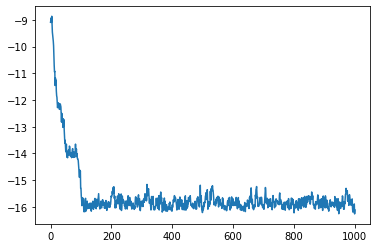

In [21]:
plt.plot(y3d)

In [12]:
X3d_800 = X3d
y3d_800 = y3d

In [10]:
X3d_10 = X3d
y3d_10 = y3d

## Task 3: MC sampling and dataset for 2D LJ cluster

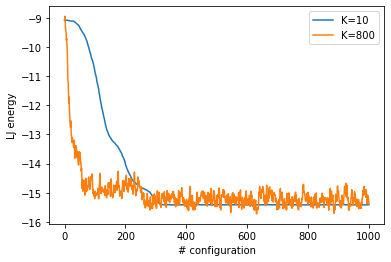

In [13]:
plt.plot(y3d_10,label='K=10')
plt.plot(y3d_800,label='K=800')
plt.ylabel('LJ energy')
plt.xlabel('# configuration')
plt.legend()

In [19]:
print(y3d_800[1000],y3d_10[1000])

-14.472449808962205 -15.410501394288527


In [17]:
# start with original setup
clus2d.set_positions(clus2d_orig_pos)

# set dimensionality
D = 2

# set temperature (in K)
#T = 200
T = 2000

# set number of MC steps
mcsteps = 20001

# displacement
#sigma = 0.005
sigma = 0.02

# how often to print energy
nprint = 500

# how often to collect data
ncollect = 20

# initialize acceptance counter
nacc = 0
X2d = []
y2d = []

# do a simple MC sampling to create a set of configurations
for i in range(mcsteps):
    
    clus2d, acc = mcstep(clus2d, T, sigma, D, rng)
    
    if acc:
        nacc += 1
    if (i % nprint) == 0:
        print(i,clus2d.get_potential_energy())
        
    if (i % ncollect) == 0:
        dist = clus2d.get_all_distances()
        dist = np.trim_zeros(np.sort(np.ravel(dist)))
        X2d.append(dist[::2])
        y2d.append(clus2d.get_potential_energy())
        
# print acceptances
#print(nacc)
print(f'\nAcceptance ratio: {float(nacc)/float(mcsteps):5.3f}')

#X2d_200 = np.array(X2d)
#y2d_200 = np.array(y2d)

X2d_2000 = np.array(X2d)
y2d_2000 = np.array(y2d)

# print(len(X2d_200))
# print(len(y2d_200))

print(len(X2d_2000))
print(len(y2d_2000))

# T = 2000 K, sigma = 0.02
# T = 200 K, sigma = 0.005

0 -12.419758307142516
500 -11.872068676276538
1000 -11.278009272369129
1500 -11.703155737176592
2000 -11.291858553623667
2500 -11.655977715602717
3000 -11.823864027142449
3500 -12.03814917892838
4000 -12.11813010988641
4500 -11.8359217225485
5000 -11.191079939986937
5500 -11.095182202553453
6000 -11.437594871499893
6500 -10.794982556384365
7000 -11.714198214562872
7500 -11.392305591956433
8000 -10.626943168934897
8500 -10.720381550879154
9000 -10.77128696297459
9500 -11.333119808197619
10000 -11.304404748346194
10500 -12.007769135441862
11000 -10.989917307621456
11500 -12.109678292219948
12000 -11.745036312928383
12500 -9.1112997411343
13000 -10.713006394921127
13500 -11.330477419626408
14000 -10.68185753805334
14500 -11.671388666061166
15000 -11.467749792935983
15500 -11.117852816017496
16000 -10.934218841073147
16500 -11.376329502748915
17000 -11.45907239230054
17500 -11.511498156514307
18000 -12.013537317631396
18500 -11.639232456962937
19000 -10.786209437198202
19500 -10.2301520434